# Import appropriate modules

In [1]:
import numpy as np
from numpy.linalg import eigh
np.set_printoptions(threshold=np.inf, linewidth=np.inf)

import diatom.hamiltonian as hamiltonian
from diatom.constants import Rb87Cs133

import scipy.constants

import matplotlib.pyplot as plt

plt.rcParams["text.usetex"] = True
plt.rcParams["figure.autolayout"] = True
plt.rcParams['figure.figsize'] = (4, 3.5)
plt.rcParams['figure.dpi'] = 200

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'

# Define constants

In [2]:
Nmax=2
H0,Hz,Hdc,Hac = hamiltonian.build_hamiltonians(Nmax,Rb87Cs133,zeeman=True,Edc=True,ac=True)

I = 0 #W/m^2
E = 0 #V/m
B = np.linspace(1, 250, 50)*1e-4 #T

H = H0[..., None]+\
    Hz[..., None]*B+\
    Hdc[..., None]*E+\
    Hac[..., None]*I
H = H.transpose(2,0,1)

energies, states = eigh(H)

<IPython.core.display.Javascript object>


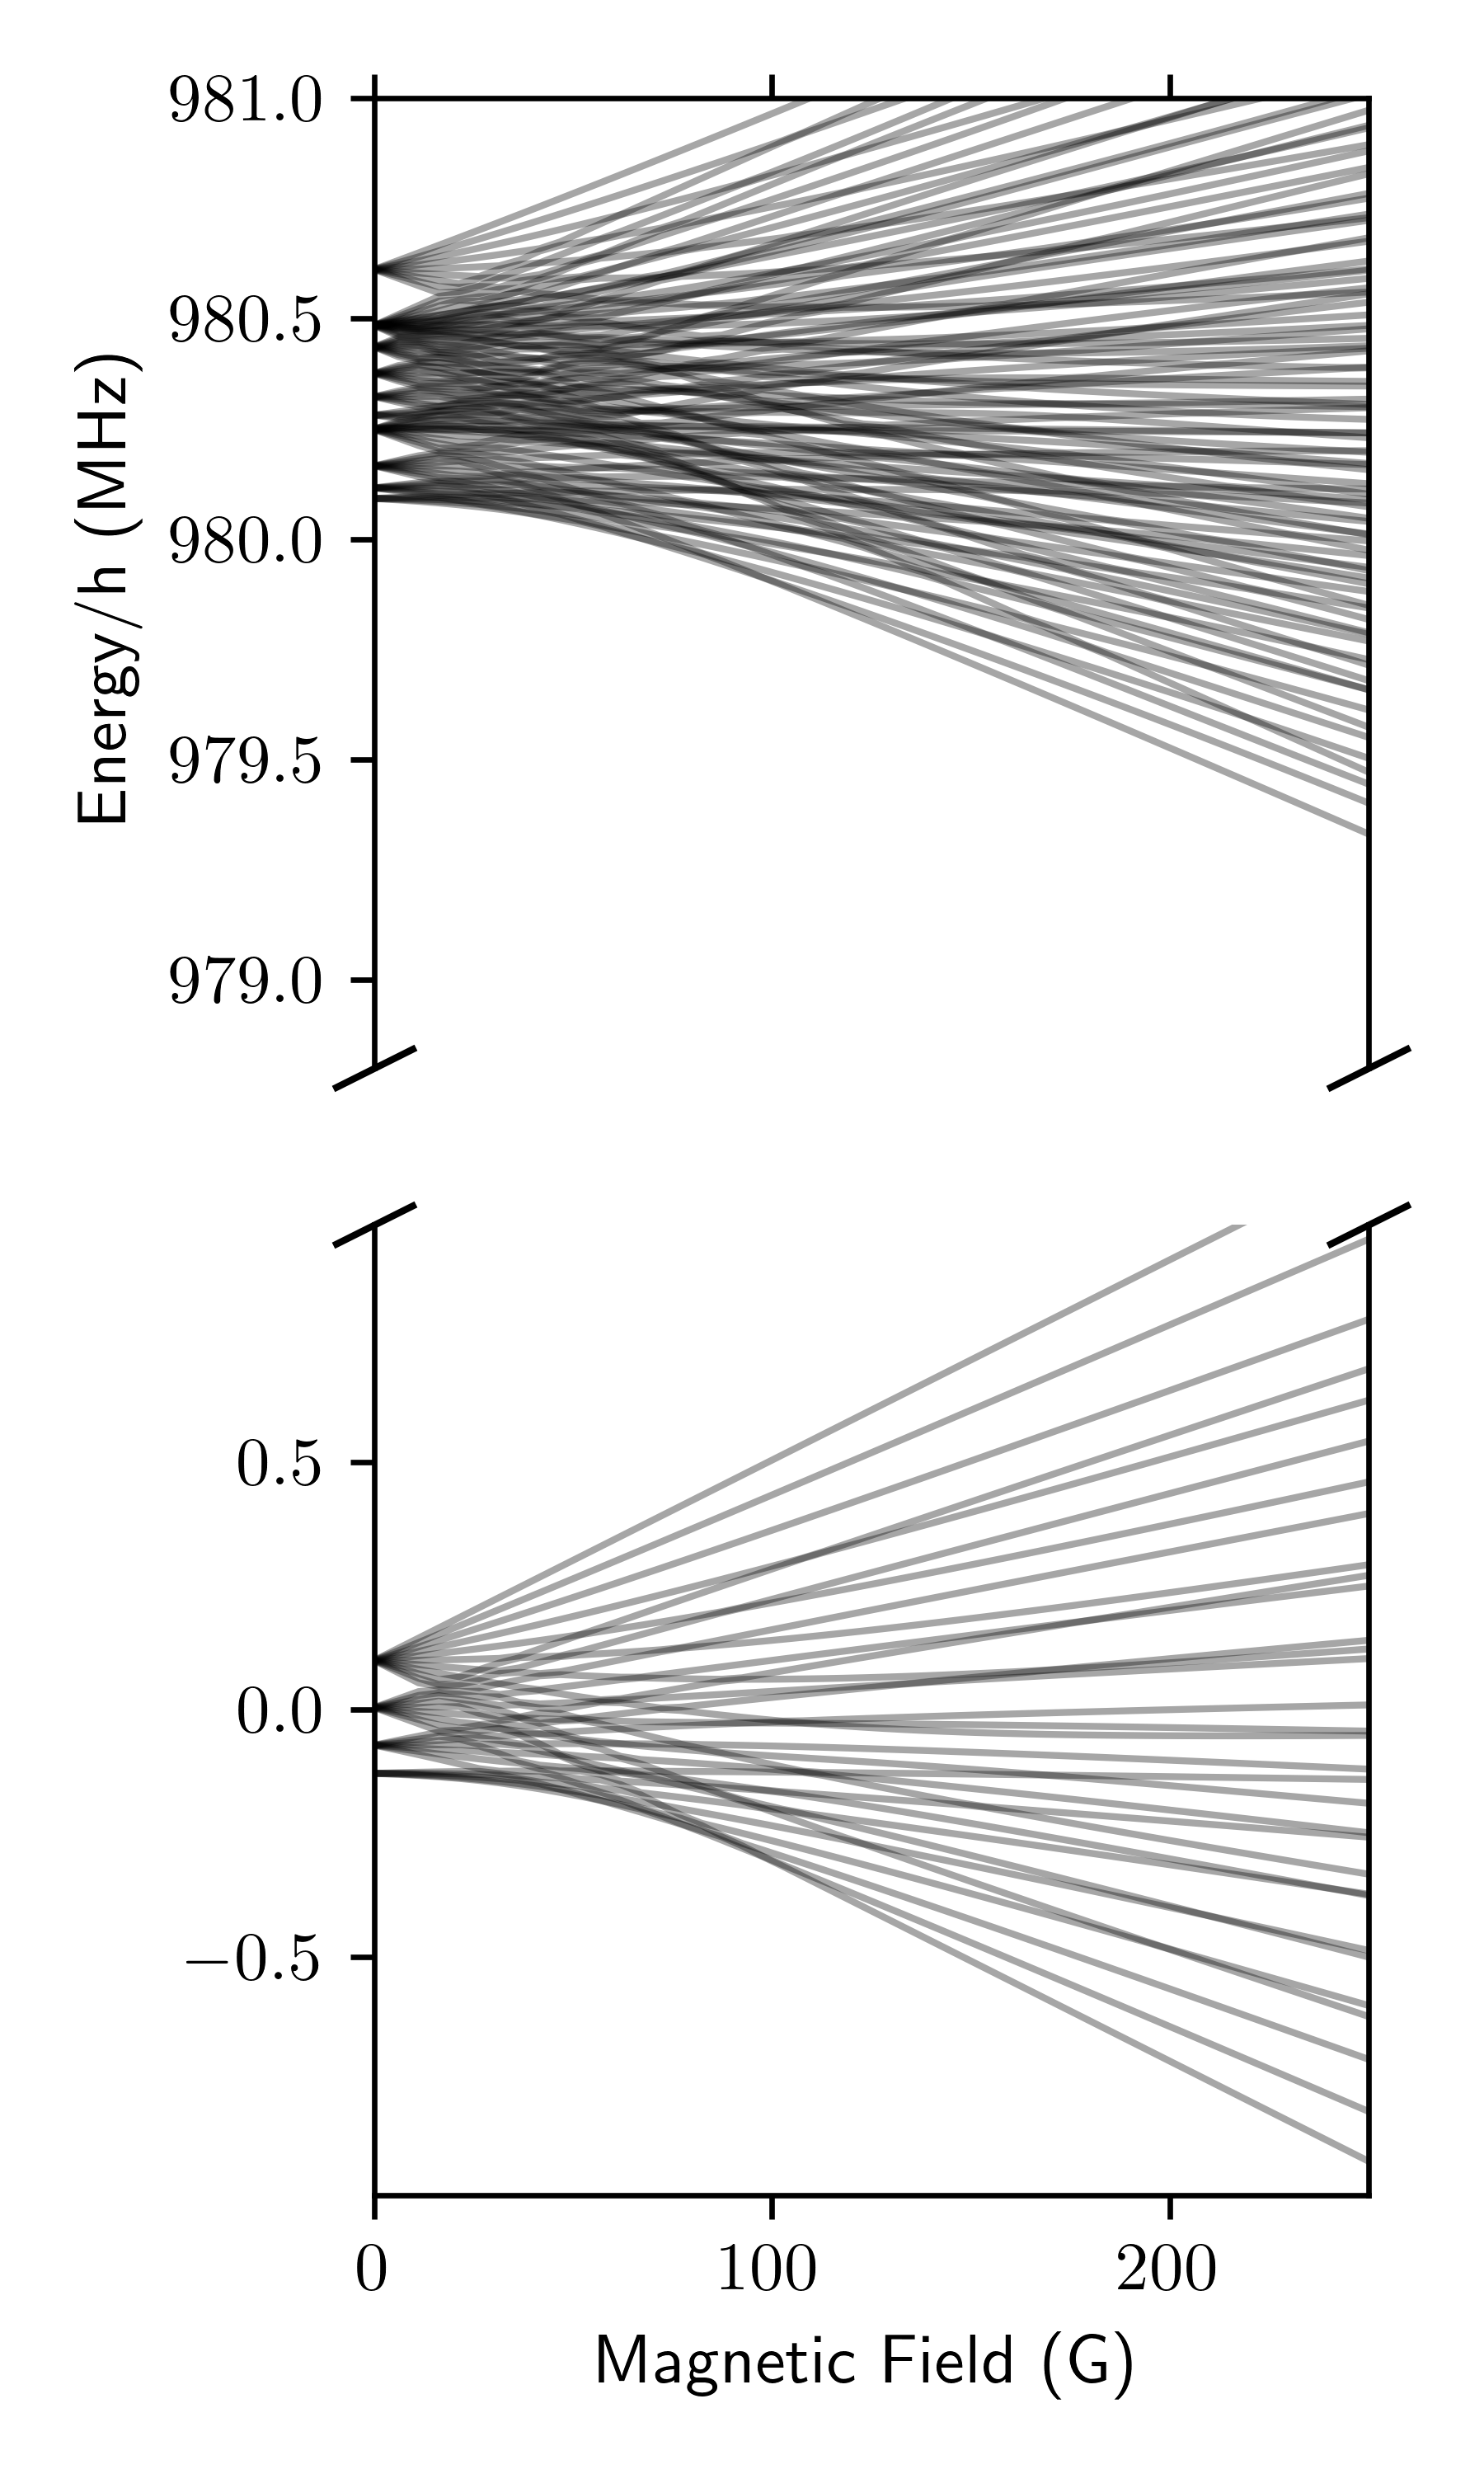

In [3]:
fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,figsize=(3,5),dpi=300)

ax1.plot(B*1e4, energies*1e-6/scipy.constants.h, color='k', linewidth=1, alpha=0.35)
ax2.plot(B*1e4, energies*1e-6/scipy.constants.h, color='k', linewidth=1, alpha=0.35)

ax1.set_ylim(978.8, 981.0)
ax2.set_ylim(-0.98, 0.98)

# hide the spines between ax1 and ax2
ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.xaxis.tick_top()
ax1.tick_params(labeltop=False)  # don't put tick labels at the top
ax2.xaxis.tick_bottom()


d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)


ax1.set_xlim(0, 250)
ax1.set_ylabel("Energy/h (MHz)")
ax2.set_xlabel("Magnetic Field (G)")
fig.show()

<IPython.core.display.Javascript object>


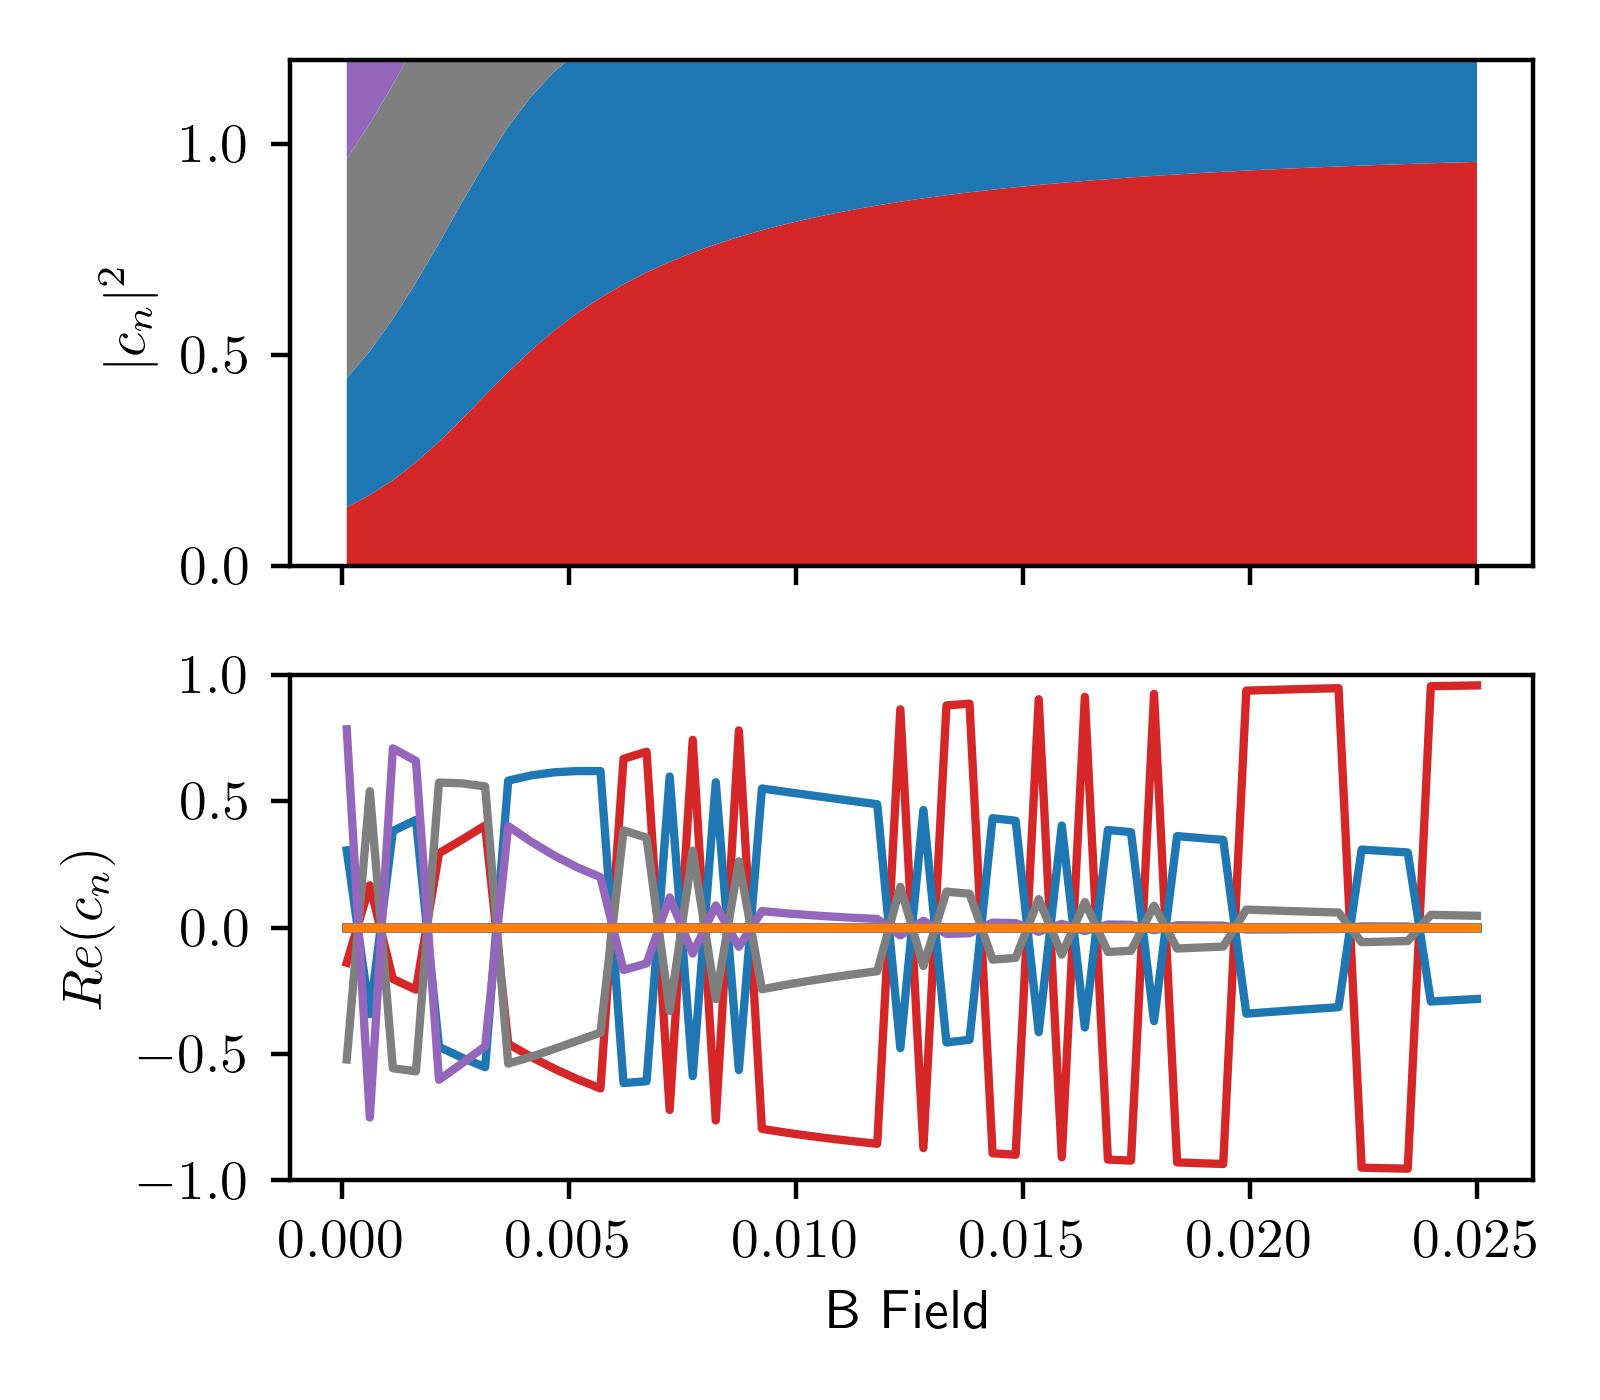

In [4]:
def sort_smooth(in_energies, in_states):
    """Sort states to remove false avoided crossings.

    This is a function to ensure that all eigenstates plotted change
    adiabatically, it does this by assuming that step to step the eigenstates
    should vary by only a small amount (i.e. that the  step size is fine) and
    arranging states to maximise the overlap one step to the next.

    Args:
        Energy (numpy.ndarray) : numpy.ndarray containing the eigenergies, as from numpy.linalg.eig
        States (numpy.ndarray): numpy.ndarray containing the states, in the same order as Energy
    Returns:
        Energy (numpy.ndarray) : numpy.ndarray containing the eigenergies, as from numpy.linalg.eig
        States (numpy.ndarray): numpy.ndarray containing the states, in the same order as Energy E[x,i] -> States[x,:,i]
    """
    ls = np.arange(in_states.shape[2], dtype="int")
    number_iterations = len(in_energies[:, 0])
    for i in range(1, number_iterations):
        """
        This loop sorts the eigenstates such that they maintain some
        continuity. Each eigenstate should be chosen to maximise the overlap
        with the previous.
        """
        # calculate the overlap of the ith and jth eigenstates
        overlaps = np.einsum(
            "ij,ik->jk", np.conjugate(in_states[i - 1, :, :]), in_states[i, :, :]
        )
        orig2 = in_states[i, :, :].copy()
        orig1 = in_energies[i, :].copy()
        # insert location of maximums into array ls
        np.argmax(np.abs(overlaps), axis=1, out=ls)
        for k in range(in_states.shape[2]):
            l = ls[k]
            if l != k:
                in_energies[i, k] = orig1[l].copy()
                in_states[i, :, k] = orig2[:, l].copy()
    return in_energies, in_states


energies, states = sort_smooth(energies, states)


fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

state = 0
probs, reals = [], []
for coefn in range(192):
    probs.append(np.abs(states[:, coefn, state]))
    reals.append(states[:, coefn, state].real)

ax1.stackplot(B, probs)
ax1.set_ylabel(r"$|c_n|^2$")
ax1.set_ylim(0, 1.2)

ax2.plot(B, np.array(reals).transpose(1, 0))
ax2.set_xlabel("B Field")
ax2.set_ylabel(r"$Re(c_n)$")
ax2.set_ylim(-1, 1)

fig.show()